# Transfer Learning and Transformers

## Overview

### Dataset

##### **Classification Task:**

The classification task in this dataset is to correctly classify a playing card image into one of 53 classes, where each class corresponds to a specific card type and suit combination. This includes 13 card types (from 1 to 10, Jack, Queen, King, and Ace) and 4 suits (diamonds, hearts, spades, and clubs), resulting in a total of 53 possible classes.

**Is this Classification Task Single-Task or Multi-Task?**

This classification task is considered a single-task classification problem. In multi-task learning, the model is trained to perform multiple related tasks simultaneously. In this dataset, there is only one task: classifying the playing card images into their respective classes. Although there are two aspects to consider (card type and suit), they are not treated as separate tasks but rather as different categories within the same classification task.

**Overview of the dataset:**

- **Number of Classes**: 53 (13 card types × 4 suits + 1 for "no card" class)
- **Image Size**: 224 x 224 x 3 (RGB format)
- **Training Images**: 7,624
- **Test Images**: 265
- **Validation Images**: 265
- **Directory Structure**: The dataset is partitioned into three directories (train, test, and validation), each containing 53 subdirectories corresponding to the 53 classes. Each subdirectory contains images of a specific card type and suit combination.
- **CSV File**: The dataset includes a CSV file that can be used to load and manage the datasets, providing additional metadata if needed.

This dataset provides a comprehensive collection of high-quality playing card images suitable for training and evaluating image classification models.

##### **Feature Data:**

In the Card Dataset, the feature data refers to the characteristics or attributes of the playing card images that are used for classification. In this dataset, the feature data consists of the pixel values of the images. Each image is represented as a grid of pixels, where each pixel contains information about the color and intensity at that particular location.

Specifically, the feature data in the Card Dataset includes:
1. **Image Pixel Values**: Each image in the dataset is represented by a matrix of pixel values, typically organized in height, width, and color channels (e.g., red, green, blue). For example, a 224x224x3 image would have dimensions of 224 pixels in height, 224 pixels in width, and 3 color channels (RGB).

These pixel values serve as the input features for the classification model. The model learns patterns and relationships within the pixel values to classify each image into one of the 53 classes corresponding to different types and suits of playing cards.

**Data Collection:**

Regarding the collection of the data, the source and the entity responsible for collecting the dataset are not explicitly mentioned in the provided information. Without specific details, it's challenging to determine who collected the data, why, and when. However, datasets like these are often collected for various purposes such as research, development of machine learning models for image recognition or classification, educational purposes, or even for recreational purposes like creating playing card games or applications.

Typically, such datasets are created by individuals or organizations with an interest in computer vision, artificial intelligence, or gaming-related applications. The collection process may involve sourcing images from various sources, such as public domain image repositories, online databases, or through manual image capture and annotation. As for the timeline of data collection, it can vary widely depending on the context and the objectives of the dataset creators.


**Is this data single-modal or multi-modal?**

The provided dataset of playing card images is not considered multi-modal. Multi-modal datasets typically contain data from multiple distinct modalities, such as images, text, audio, or sensor data. In this dataset, the modality is consistent throughout, consisting solely of image data in JPG format

##### **Evaluation Critieria:**


**Evaluation Metric:**

For evaluating the Card dataset classification model, we chose **accuracy** for the reasons listed below.

**Balanced Dataset:**

Since the dataset is roughly balanced with respect to the number of images in each class, the risk of a biased accuracy metric towards more prevalent classes is minimized. In scenarios where datasets are imbalanced, accuracy can give a skewed perception of model performance, favoring the majority class. However, in our case, the even distribution of classes ensures that the accuracy metric provides a fair evaluation of the model's ability to classify cards correctly.

**Cost of Misclassification:**

The problem statement does not differentiate between the costs associated with false positives and false negatives. This implies that all types of classification errors are treated equally. Under these circumstances, accuracy, which calculates the proportion of correct predictions (true positives and true negatives) to the total predictions, serves as a suitable metric. It straightforwardly reflects the model's overall performance without needing to account for the varying impacts of different types of errors.

### Vision Transformer (ViT)

**Overview:**

The Vision Transformer (ViT)  is a groundbreaking approach in the field of computer vision, introduced by a team of Google researchers including Alexey Dosovitskiy in the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." ViT applies the transformer architecture, which was originally developed for natural language processing tasks, to image classification. The model treats an image as a sequence of patches and processes these patches similarly to how words (tokens) are processed in NLP tasks. Like the original transformer described in the paper writen by Ashish Vaswani, et. al., the ViT uses the concept of attention on these patches. Attention works by computing relevance scores between different parts of the input data. The attention mechanism computes scores to determine how much focus should be placed on components of the image being processed. This is achieved through three main components: queries, keys, and values, which are derived from the input data through learned transformations.

![title](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

**ViT Training:**

The foundational ViT model was trained on large-scale image datasets such as ImageNet. These datasets cover a wide range of image classification tasks, featuring millions of images across thousands of categories. The training involves learning to correctly classify images into their respective categories based on the visual patterns and features present in the images. In our case, we will use ViT trained on ImageNet-21k.

**ViT Training Tasks:**
* Image Classification - The primary task ViT was trained on is image classification, where the goal is to assign a single label (or multiple labels) to an image from a predefined set of categories.
* General Feature Learning - Although the explicit task is image classification, during training, ViT inherently learns to extract and understand various visual features and patterns, which are useful for a broad range of vision tasks beyond just classification.

**Domain Consideration:**

The task of classifying images of playing cards falls within the broader domain of image classification, which is the primary domain ViT was trained on. Therefore, the new task is within the same domain as the foundational model's training tasks. However, it's a more specific and potentially narrower task compared to the broad and diverse set of categories found in datasets like ImageNet.

## Code

### Data Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import math
from tensorflow.keras import utils, layers, Sequential, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import random
import pickle
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
        zip_ref.close()

    train = utils.image_dataset_from_directory('/content/data/archive/train', image_size=(224,224), batch_size=32)
    test = utils.image_dataset_from_directory('/content/data/archive/test', image_size=(224,224), batch_size=32)
    folder_path = "/content/data/archive/"
else:
    train = utils.image_dataset_from_directory('/Users/cameronervin/Documents/Spring 2024/CS 8321/Lab 2/data/archive/train', image_size=(224,224), batch_size=32)
    test = utils.image_dataset_from_directory('/Users/cameronervin/Documents/Spring 2024/CS 8321/Lab 2/data/archive/test', image_size=(224,224), batch_size=32)
    folder_path = "/Users/cameronervin/Documents/Spring 2024/CS 8321/Lab 2/data/archive/"

Mounted at /content/drive
Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [3]:
class_names = train.class_names

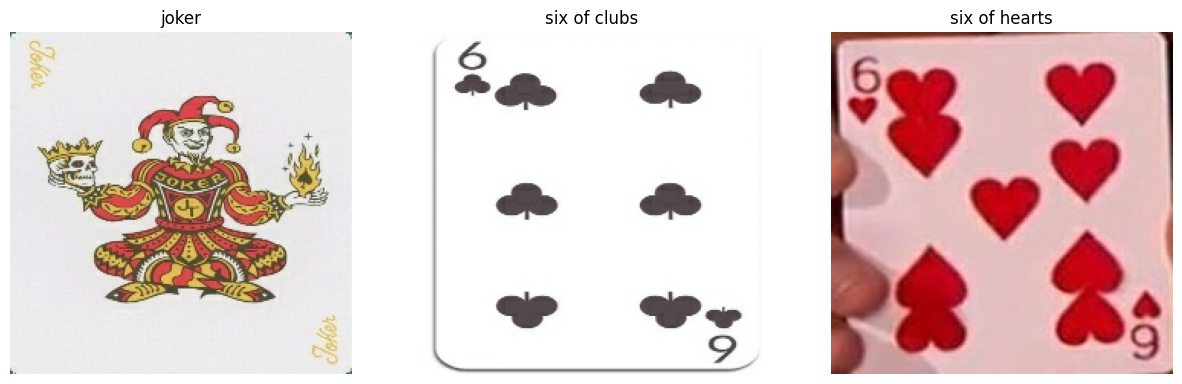

In [4]:
def show_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

for images, labels in train.take(1):
    show_images(images, labels, class_names)

### Models

#### Building a Model From Scratch

For our model built from scratch, we will create a Convolutional Neural Network. First, let's load our data in seperately from our previous data load because we will also augment our data before running it through our CNN.

In [5]:
batch_size  = 32
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = class_names,
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                        brightness_range=(0.,2.),
                                        rescale=1./255,
                                        shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "valid",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = batch_size,
                                                              class_mode = 'categorical',
                                                              classes = class_names,
                                                              shuffle = False)


datagen_test = ImageDataGenerator(horizontal_flip = True,
                                  brightness_range=(0.,2.),
                                  rescale=1./255,
                                  shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                  target_size = (img_size,img_size),
                                                  color_mode = 'grayscale',
                                                  batch_size = batch_size,
                                                  classes = class_names,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


Next, we will define our CNN model.

In [6]:
# Creating sequential model
cnn = Sequential()

# Adding the first Convolutional block
cnn.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (48, 48, 1)))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU(0.1))
cnn.add(MaxPooling2D(pool_size = 2))

# Adding the second Convolutional block
cnn.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU(0.1))
cnn.add(MaxPooling2D(pool_size = 2))

# Adding the third Convolutional block
cnn.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU(0.1))
cnn.add(MaxPooling2D(pool_size = 2))

# Adding the fourth Convolutional block
cnn.add(Conv2D(filters = 256, kernel_size = 2, padding = "same", activation = "relu"))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(LeakyReLU(0.1))
cnn.add(MaxPooling2D(pool_size = 2))

# Adding the Flatten layer
cnn.add(Flatten())

# Adding Dense layers
cnn.add(Dense(512, activation = "relu"))
cnn.add(Dense(128, activation = "relu"))
cnn.add(Dense(53, activation = "softmax"))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        160       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        8

In [7]:
if colab:
  from tensorflow.keras.optimizers import Adam

  optimizer = tf.optimizers.Adam
else:
  optimizer = tf.keras.optimizers.legacy.Adam

cnn.compile(optimizer=optimizer(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

We will also add a callback function to save our history to csv. We will use our CSV files to perform statistical analysis.

In [8]:
csv_logger = tf.keras.callbacks.CSVLogger('cnn_metrics.csv')

In [9]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

We will run our model to convergence with an early stopping callback if the model does not improve in 10 epochs.

In [10]:
start = time.time()

cnn_history = cnn.fit(train_set,
                 steps_per_epoch = train_set.n//train_set.batch_size,
                 epochs = 200,
                 validation_data = validation_set,
                 validation_steps = validation_set.n//validation_set.batch_size,
                 validation_split=0.2,
                 callbacks=[callbacks,csv_logger]
)

cnn_time = time.time() - start
print("CNN Time:", cnn_time)

Epoch 1/200
238/238 [==============================] - 21s 54ms/step - loss: 3.7768 - accuracy: 0.0720 - val_loss: 4.0563 - val_accuracy: 0.0195
Epoch 2/200
238/238 [==============================] - 12s 51ms/step - loss: 3.1061 - accuracy: 0.1774 - val_loss: 3.5218 - val_accuracy: 0.0820
Epoch 3/200
238/238 [==============================] - 12s 51ms/step - loss: 2.5749 - accuracy: 0.2641 - val_loss: 2.3503 - val_accuracy: 0.3477
Epoch 4/200
238/238 [==============================] - 12s 50ms/step - loss: 2.2709 - accuracy: 0.3533 - val_loss: 1.8962 - val_accuracy: 0.4180
Epoch 5/200
238/238 [==============================] - 12s 50ms/step - loss: 2.0591 - accuracy: 0.4175 - val_loss: 1.6207 - val_accuracy: 0.5352
Epoch 6/200
238/238 [==============================] - 12s 51ms/step - loss: 1.9223 - accuracy: 0.4589 - val_loss: 1.5414 - val_accuracy: 0.5391
Epoch 7/200
238/238 [==============================] - 12s 51ms/step - loss: 1.8011 - accuracy: 0.4949 - val_loss: 1.5275 - val_ac

Let's visualize our CNN model's performance.

In [11]:
def plot_training_validation_acc(history, name, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.savefig(f"{name}_accuracy.png")

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig(f"{name}_loss.png")

    plt.show()

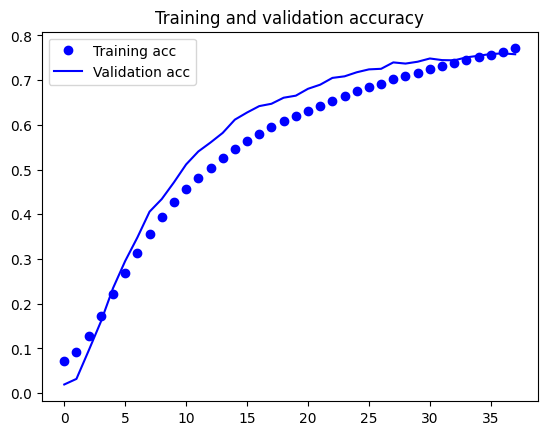

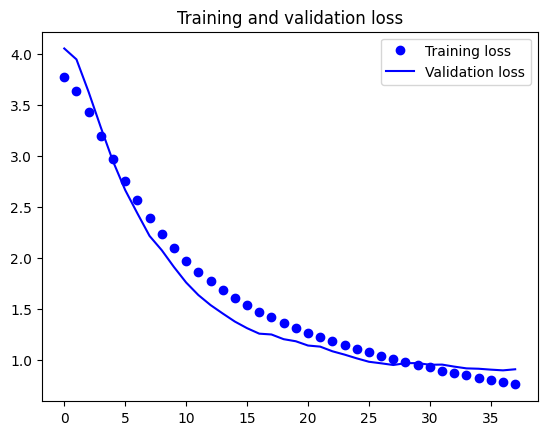

In [12]:
plot_training_validation_acc(cnn_history, name = "CNN", smooth = True)

In [13]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(test_set)
print('test acc:', cnn_test_acc)

9/9 [==============================] - 1s 75ms/step - loss: 1.1129 - accuracy: 0.6792
test acc: 0.6792452931404114


We will also, use the pickle library to save our performance metrics for later analysis.

In [14]:
f = open('store_cnn.pckl', 'wb')
pickle.dump([cnn_history,cnn_test_loss,cnn_test_acc,cnn_time],f)
f.close()

#### Building a Model with Transfer Learning Using a Transformer

First, we load our ViT from Hugging Face using the TFViTModel package from the Hugging Face transformers library. We use the base ViT with size 32x32 patches. Furthermore, our ViT was trained using images with 224x224 pixels from the ImageNet-21k dataset.

In [15]:
base_model = transformers.TFViTModel.from_pretrained("google/vit-base-patch32-224-in21k")
base_model.summary()

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "tf_vi_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  88045824  
                                                                 
Total params: 88045824 (335.87 MB)
Trainable params: 88045824 (335.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Based on the summary above, we know that our ViT is represented by one layer with many different sub-layers including our 12 attention heads. The gradients and trainable components of our ViT are set to trainable by default. We will freeze all attention heads so we can fine tune later.

In [16]:
vit_layer = base_model.get_layer("vit")

for attn_head in vit_layer.encoder.layer:
    attn_head.trainable = False

for i, attn_head in enumerate(vit_layer.encoder.layer):
    print(f"Attention Head {i} Trainable: {attn_head.trainable}")

Attention Head 0 Trainable: False
Attention Head 1 Trainable: False
Attention Head 2 Trainable: False
Attention Head 3 Trainable: False
Attention Head 4 Trainable: False
Attention Head 5 Trainable: False
Attention Head 6 Trainable: False
Attention Head 7 Trainable: False
Attention Head 8 Trainable: False
Attention Head 9 Trainable: False
Attention Head 10 Trainable: False
Attention Head 11 Trainable: False


Now, we will process our test and train data to the format required by our transformer. The required format is the same format of the images our vit-base-patch32-224-in21k ViT was trained on. Fortunately, Hugging Face has a way to efficiently preprocess our data using the ViTImageProcessor package from the transformer library. We tell the image processor how to process our data by giving it the same input as our model.

In [17]:
processor = transformers.ViTImageProcessor.from_pretrained("google/vit-base-patch32-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

To extract our bottleneck features, we will run our data through the processor and into our base_model as an input. The final hidden state of our base_model is our extracted bottleneck features. Their respective labels are our bottleneck labels.

In [18]:
def extract_features(dataset, model, processor):
    features = []
    labels = []

    for images, labels_batch in tqdm.tqdm(dataset, desc="Extracting Features", unit="batch"):
        inputs = processor(images, return_tensors="tf", padding=True, truncation=True)
        outputs = model(inputs)
        last_hidden_state = outputs.last_hidden_state
        features.append(last_hidden_state.numpy())
        labels.append(labels_batch.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

In [19]:
train_features, train_labels = extract_features(train, base_model, processor)
test_features, test_labels = extract_features(test, base_model, processor)

Extracting Features:   0%|          | 0/239 [00:00<?, ?batch/s]

Extracting Features:   0%|          | 0/9 [00:00<?, ?batch/s]

In [20]:
print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)

Train Features Shape: (7624, 50, 768)
Test Features Shape: (265, 50, 768)


For the purpose of speed, we will now convert our extracted features and labels into a TensorFlow dataset of tensors with a batch size of 32.

In [21]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(batch_size)

Now, to create our top_model, or the model we will add to our transfer model, we create a sequential Keras model.

In [22]:
top_model = Sequential([
    layers.Input(shape=(50, 768)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(53, activation='softmax')
])

In [23]:
top_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [24]:
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 38400)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              39322624  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)              

In [25]:
csv_logger = tf.keras.callbacks.CSVLogger('untuned_metrics.csv')

In [26]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

We now train our top_model with our extracted features and labels. Additionally, we will run our model to convergence with an early stopping callback if the model does not improve in 10 epochs.

In [27]:
start = time.time()

untuned_history = top_model.fit(train_dataset, validation_data=test_dataset, callbacks=[callbacks,csv_logger], epochs=200)

untuned_time = time.time() - start
print(f"Time: {untuned_time}")

Epoch 1/200
239/239 [==============================] - 5s 15ms/step - loss: 3.5065 - accuracy: 0.1058 - val_loss: 2.4428 - val_accuracy: 0.3094
Epoch 2/200
239/239 [==============================] - 3s 14ms/step - loss: 2.5523 - accuracy: 0.2795 - val_loss: 1.7219 - val_accuracy: 0.4868
Epoch 3/200
239/239 [==============================] - 3s 14ms/step - loss: 1.9738 - accuracy: 0.4175 - val_loss: 1.3423 - val_accuracy: 0.5962
Epoch 4/200
239/239 [==============================] - 3s 14ms/step - loss: 1.5604 - accuracy: 0.5310 - val_loss: 1.0579 - val_accuracy: 0.7132
Epoch 5/200
239/239 [==============================] - 3s 14ms/step - loss: 1.2500 - accuracy: 0.6237 - val_loss: 0.8840 - val_accuracy: 0.7509
Epoch 6/200
239/239 [==============================] - 3s 13ms/step - loss: 1.0105 - accuracy: 0.6891 - val_loss: 0.8611 - val_accuracy: 0.7283
Epoch 7/200
239/239 [==============================] - 3s 14ms/step - loss: 0.8125 - accuracy: 0.7440 - val_loss: 0.7432 - val_accuracy:

Now, to plot our accuracy and loss.

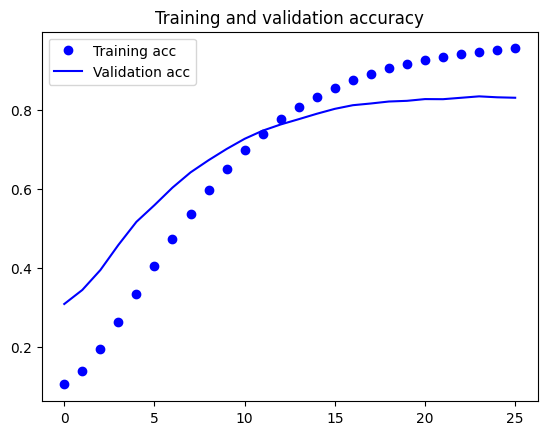

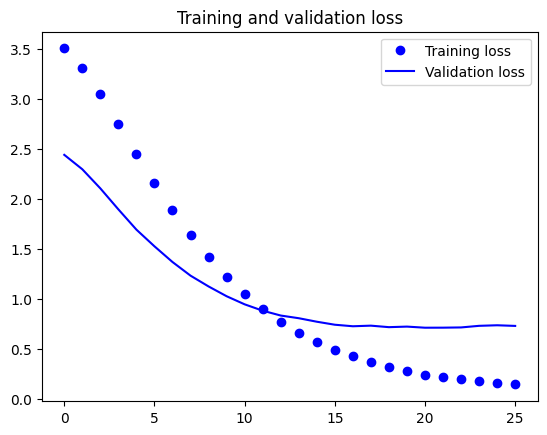

In [28]:
plot_training_validation_acc(untuned_history, name = "Untuned", smooth = True)

In [29]:
untuned_test_loss, untuned_test_acc = top_model.evaluate(test_dataset)
print('test acc:', untuned_test_acc)

9/9 [==============================] - 0s 5ms/step - loss: 0.6234 - accuracy: 0.8528
test acc: 0.852830171585083


#### Fine Tuning Our Transfer Learning Model

Next, we will change several of our attention heads to trainable. This is done to fine tune the performance of our model without losing the pretrained weights of our base ViT. In order to do so, we iterate through our attention heads and set the last three to trainable.

In [30]:
n_trainable_heads = 3

for attn_head in vit_layer.encoder.layer[-n_trainable_heads:]:
    attn_head.trainable = True

for i, attn_head in enumerate(vit_layer.encoder.layer):
    print(f"Attention Head {i} Trainable: {attn_head.trainable}")

Attention Head 0 Trainable: False
Attention Head 1 Trainable: False
Attention Head 2 Trainable: False
Attention Head 3 Trainable: False
Attention Head 4 Trainable: False
Attention Head 5 Trainable: False
Attention Head 6 Trainable: False
Attention Head 7 Trainable: False
Attention Head 8 Trainable: False
Attention Head 9 Trainable: True
Attention Head 10 Trainable: True
Attention Head 11 Trainable: True


Since our model is now different, we re-extract our bottleneck features and labels using the same function as before. Next, we will compile and train our new model using the same top_model as before. However, we will use a smaller learning rate than before.

In [31]:
train_features, train_labels = extract_features(train, base_model, processor)
test_features, test_labels = extract_features(test, base_model, processor)

Extracting Features:   0%|          | 0/239 [00:00<?, ?batch/s]

Extracting Features:   0%|          | 0/9 [00:00<?, ?batch/s]

In [32]:
top_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

We will run our model to convergence with an early stopping callback if the model does not improve in 10 epochs.

In [33]:
csv_logger = tf.keras.callbacks.CSVLogger('tuned_metrics.csv')

In [34]:
start = time.time()

tuned_history = top_model.fit(train_dataset, validation_data=test_dataset, callbacks=[callbacks,csv_logger], epochs=200)

tuned_time = time.time() - start
print(f"Time: {tuned_time}")

Epoch 1/200
239/239 [==============================] - 4s 14ms/step - loss: 0.1069 - accuracy: 0.9696 - val_loss: 0.5649 - val_accuracy: 0.8679
Epoch 2/200
239/239 [==============================] - 3s 13ms/step - loss: 0.0821 - accuracy: 0.9765 - val_loss: 0.5741 - val_accuracy: 0.8679
Epoch 3/200
239/239 [==============================] - 3s 13ms/step - loss: 0.0778 - accuracy: 0.9797 - val_loss: 0.5830 - val_accuracy: 0.8604
Epoch 4/200
239/239 [==============================] - 3s 12ms/step - loss: 0.0732 - accuracy: 0.9801 - val_loss: 0.5576 - val_accuracy: 0.8642
Epoch 5/200
239/239 [==============================] - 3s 13ms/step - loss: 0.0658 - accuracy: 0.9827 - val_loss: 0.5631 - val_accuracy: 0.8717
Epoch 6/200
239/239 [==============================] - 3s 13ms/step - loss: 0.0616 - accuracy: 0.9805 - val_loss: 0.5704 - val_accuracy: 0.8679
Epoch 7/200
239/239 [==============================] - 3s 13ms/step - loss: 0.0589 - accuracy: 0.9848 - val_loss: 0.5774 - val_accuracy:

Let's visualize our fine-tuned model's performance.

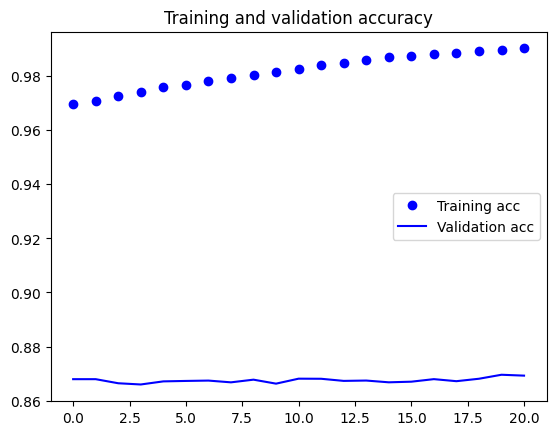

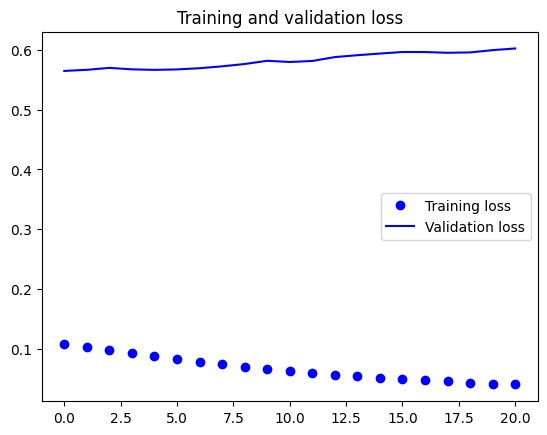

In [35]:
plot_training_validation_acc(tuned_history, name = "Tuned", smooth = True)

In [36]:
tuned_test_loss, tuned_test_acc = top_model.evaluate(test_dataset)
print('test acc:', tuned_test_acc)

9/9 [==============================] - 0s 5ms/step - loss: 0.5719 - accuracy: 0.8755
test acc: 0.8754717111587524


In [37]:
for images, labels in test_dataset.take(1):
    # Predict the labels for this batch
    predictions = top_model.predict(images)
    predicted_labels_indices = tf.argmax(predictions, axis=1)

    # Convert predicted label indices to class names
    predicted_labels_names = [class_names[index] for index in predicted_labels_indices.numpy()]

    actual_labels_names = [class_names[index] for index in labels.numpy()]

    # Create a DataFrame for a better display
    df = pd.DataFrame({
        'Predicted Labels': predicted_labels_names,
        'Actual Labels': actual_labels_names
    })

    # Display the DataFrame
    print('Note - we chose to visualize the labels of our data rather than unflattening and unprocessing our data before display')
    print(df)

1/1 [==============================] - 0s 121ms/step
Note - we chose to visualize the labels of our data rather than unflattening and unprocessing our data before display
     Predicted Labels      Actual Labels
0      king of hearts   king of diamonds
1       jack of clubs      jack of clubs
2   three of diamonds  three of diamonds
3       four of clubs      four of clubs
4       ace of spades      ace of spades
5     queen of spades    queen of spades
6      five of spades     five of spades
7     three of hearts      two of hearts
8       nine of clubs      nine of clubs
9     eight of spades      five of clubs
10      king of clubs     king of spades
11      five of clubs      five of clubs
12     five of hearts     five of hearts
13   four of diamonds   four of diamonds
14      six of spades      six of spades
15      six of hearts      six of hearts
16       six of clubs       six of clubs
17     five of spades     five of spades
18    queen of hearts    queen of hearts
19      t

In [38]:
f = open('store_noncnn.pckl', 'wb')
pickle.dump([untuned_history,tuned_history,
             untuned_test_loss,untuned_test_acc,
             tuned_test_loss,tuned_test_acc,
             untuned_time,tuned_time], f)
f.close()

## Analysis

In [39]:
f = open('store_noncnn.pckl', 'rb')
untuned_history,tuned_history,untuned_test_loss,untuned_test_acc,tuned_test_loss,tuned_test_acc,untuned_time,tuned_time = pickle.load(f)
f.close()

In [40]:
print(f"Untuned History: {untuned_history}\n"
      f"Tuned History: {tuned_history}\n"
      f"Untuned Test Loss: {untuned_test_loss}\n"
      f"Untuned Test Accuracy: {untuned_test_acc}\n"
      f"Tuned Test Loss: {tuned_test_loss}\n"
      f"Tuned Test Accuracy: {tuned_test_acc}\n"
      f"Untuned Time: {untuned_time}\n"
      f"Tuned Time: {tuned_time}")


Untuned History: <keras.src.callbacks.History object at 0x7bfb6bf8a3b0>
Tuned History: <keras.src.callbacks.History object at 0x7bfb69ec9f30>
Untuned Test Loss: 0.6233640909194946
Untuned Test Accuracy: 0.852830171585083
Tuned Test Loss: 0.5718777179718018
Tuned Test Accuracy: 0.8754717111587524
Untuned Time: 88.19131660461426
Tuned Time: 64.96874165534973


In [41]:
f = open('store_cnn.pckl', 'rb')
cnn_history,cnn_test_loss,cnn_test_acc,cnn_time = pickle.load(f)
f.close()

In [42]:
print(f"CNN History: {cnn_history}\n"
      f"CNN Test Loss: {cnn_test_loss}\n"
      f"CNN Test Accuracy: {cnn_test_acc}\n"
      f"CNN Time: {cnn_time}")

CNN History: <keras.src.callbacks.History object at 0x7bfb6bf8b700>
CNN Test Loss: 1.1128743886947632
CNN Test Accuracy: 0.6792452931404114
CNN Time: 470.73556637763977


Since the performance of each machine learning model epoch depends on previous performance, the assumptions of independence are violated, thus both the t-test and the F-test are inappropriate in this case.

To compare the best performance of the models to each other, we centered the data 10 epochs before stopping, because we set the early stopping to 10 epochs of non-improvement. Since we used Adam to optimize, to control for the learning based on previous models with momentum, we then included two lag variables. Then, the earliest epochs were omitted from the data, since they had a non-linear trend. Dummy variables (one hot) variables were constructed for each model.

### Statistical Models and Model Fit:

The following results all came from multiple linear regressions, with controls for epoch and autocorrelation (via two lagged values), and the dummy variables for Tuned and CNN models, so that the base model of the regressions was the Untuned model.

For accuracy, the overall statistical regression model had an adjusted R-squared of 0.9158 and RMSE of 0.019, thus we have evidence of a good fit of the statistical regression to the data, since almost 92 percent of the variation in the Validation Accuracy data was explained with this statistical model. Also checking the assumptions for linear regression, the statistical model doesn't obviously violate any assumptions multiple linear regression, except for potential multicollinearity between the two lag variables.

<div>
<img src="https://github.com/cameronervin/NN-Projects/blob/main/lab2/graphs/Accuracy_vs_Epochs_big.png?raw=true" width="1000"/>
</div>

For the Loss Function statistical regression model had an adjusted R-squared of 0.9162 and RMSE of 0.053, thus we have evidence of a good fit of the statistical regression to the data, since almost 92% of the variation in the Loss Function data was explained by this statistical model. The Loss Function statistical model also did not obviously violate assumptions of multiple linear regression, with a similar exception for the multicollinearity between the two lag variables, and a single extreme outlier.

<div>
<img src="https://github.com/cameronervin/NN-Projects/blob/main/lab2/graphs/Loss_vs_Epochs_big.png?raw=true" width="1000"/>
</div>

### Results of Statistical Models:

For the multiple regression on Accuracy, the Tuned model performed slightly better (2.23%) than the Untuned model, and this difference was statistically significant (p = .00337). However, the CNN model performed worse than the Untuned model (-5.47%), and this difference was statistically significant (p < 2.7e-9).

<div>
<img src="https://github.com/cameronervin/NN-Projects/blob/main/lab2/graphs/Accuracy_model_checks_big.png?raw=true" width="1000"/>
</div>

For the multiple regression on Loss Function, the overall the Tuned model was lower than the Untuned model (-0.0405) and this difference was statistically significant (p = 0.0443), but the CNN model was higher than the Untuned model (0.1448) and this difference was statistically significant (p = 2.26e-08).

<div>
<img src="https://github.com/cameronervin/NN-Projects/blob/main/lab2/graphs/loss_model_checks_big.png?raw=true" width="1000"/>
</div>

In summary, the results of the statistical tests are confirmed by the data visualizations. The CNN performance is surprisingly good, but still inferior to the transfer transformer models. Model tuning of some of the hidden layers does modestly but significantly increase Accuracy performance and decreases the Loss.

When running time is taken into account, the CNN model trained for 470 seconds, while the Untuned Transfer model trained for 88 seconds, and the Tuned model for an additional 64 seconds. The total time spent training the Tuned Transfer model was thus 152 seconds, almost a third of the time spend training the CNN model from scratch with significant Accuracy improvement of 7.7%.

## Conclusion

Transferring the ViT transformer then tuning the model produced superior accuracy faster than training a CNN model from scratch on this card sorting task.

##### References:
- [Dataset](https://www.kaggle.com/datasets/86dcbfae1396038cba359d58e258915afd32de7845fd29ef6a06158f80d3cce8)
- [Hugging Face ViT](https://huggingface.co/docs/transformers/model_doc/vit)
- [Example Notebook](https://www.kaggle.com/code/merkost/transfer-learning-image-classification)
- [Lecture Notebook](https://github.com/8000net/LectureNotesMaster/blob/master/02%20Transfer%20Learning.ipynb)
- ChatGPT4